In [239]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.decomposition import PCA
from typing import Tuple

In [240]:
# import the functions from local directory
sys.path.append("../helpers/functions")
from data_from_h5 import get_data
from spike_preprocessing import spike_band_filtering
from spike_detection import detect_spikes, merge_spike_indices, get_waveforms
from feature_extraction import pca_feature_extraction, plot_pca_features, tsne_feature_extraction, plot_tsne_features, umap_feature_extraction

In [241]:
SAMPLE_RATE = 25000
DT = 1 / SAMPLE_RATE
PRIMARY_COLOUR = "black"
T = 100000
gain = .5  
TIME = np.arange(0, T) * DT
THRESHOLD_FACTOR = -5  # set a threshold mulitplier -> heuristic
LOAD_FROM_REPO = False

In [242]:
if LOAD_FROM_REPO:
    # load csv into pandas dataframe
    df = pd.read_csv("../data/spontaneous_data.csv")

    print(df.shape)
    print(df.head())

    # choose some channels which are close to each other
    channels = ["47", "48", "49", "50"]

    # convert channel data to numpy array
    data = df[channels].values
else:

    # loading data from HDF5 file
    df = get_data(
        sample_rate=SAMPLE_RATE , 
        file_path="/Volumes/WD Passport/DataScienceProject/220113_S1_m.h5", 
        data_path="Data/Recording_0/AnalogStream/Stream_0/ChannelData", 
        start_timestamp=500, 
        duration=T * 5, 
        show_structure=True
    )

    channels = [47, 48, 49, 50]

    # convert channel data to numpy array
    data = df[channels].values


print(df.shape)
print(df.head())

Data
Data/Recording_0
Data/Recording_0/AnalogStream
Data/Recording_0/AnalogStream/Stream_0
Data/Recording_0/AnalogStream/Stream_0/ChannelData
Data/Recording_0/AnalogStream/Stream_0/ChannelDataTimeStamps
Data/Recording_0/AnalogStream/Stream_0/InfoChannel
(500000, 60)
   0   1   2   3   4   5   6   7   8   9   ...  50  51  52  53  54  55  56  \
0  29  25  -9  20  -4   8  71   8 -30 -18  ...  78  12 -45 -24  20  28  18   
1  38 -17  16  12 -13   1  64  -6 -29 -18  ...  71  14 -43 -24  14  33   8   
2  55 -23  24  31  10   4  37 -27 -10 -35  ...  52  14 -37  -5  21  22  14   
3  48  -6   8  45  19  -6   8 -33  11 -60  ...  32  12  -9  -5  29  -2   0   
4  28  22  -4  53   1 -31  -5 -30  15 -66  ...  25  22  20 -25  22  -2 -22   

   57  58  59  
0  21 -12 -24  
1   3  24  11  
2  -2  58  38  
3  10  64  27  
4  31  52  -6  

[5 rows x 60 columns]


## Raw Data

First, let's look at the raw signals from a small group of electrodes

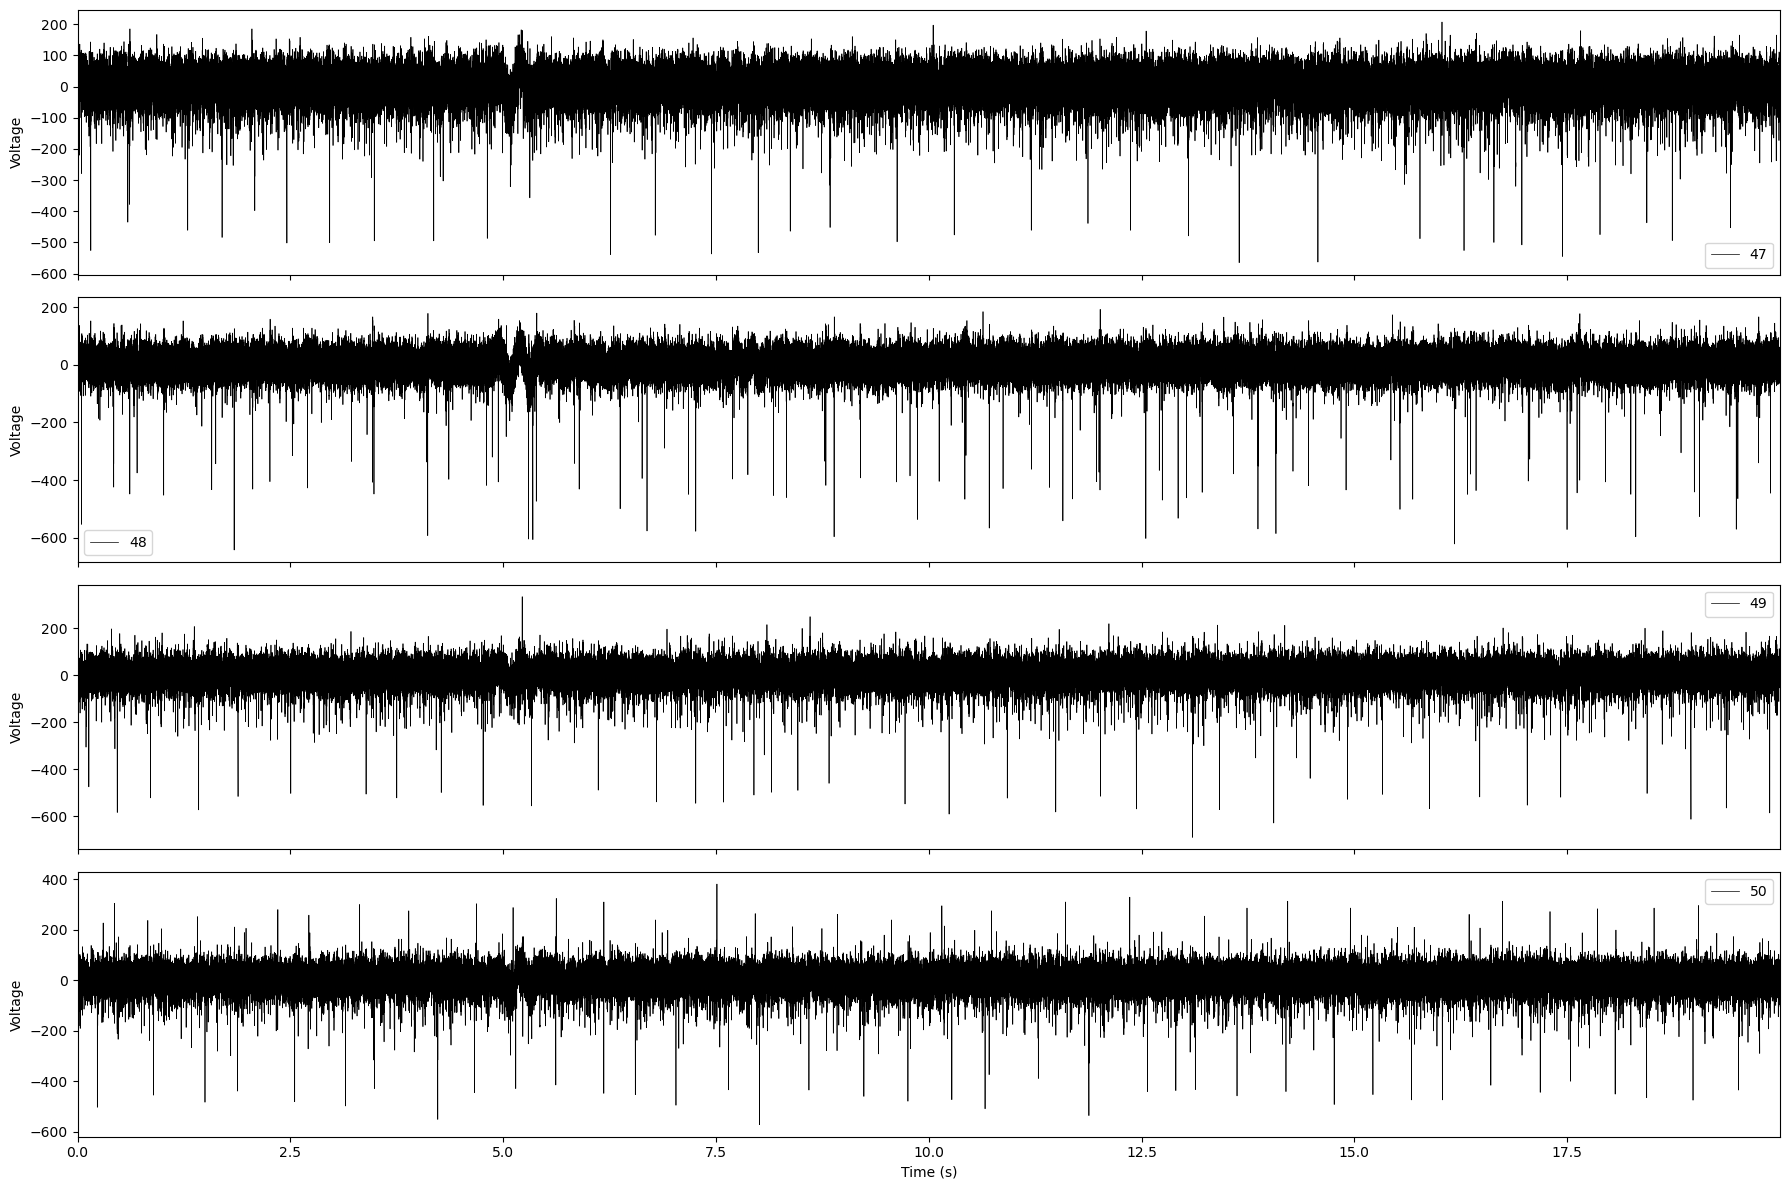

In [243]:
# create a time array for the x axis
time = np.arange(0, len(df)) / SAMPLE_RATE

fig, axs = plt.subplots(len(channels), sharex=True, figsize=(18, 3*len(channels)))

# plot each channel
for i, ax in enumerate(axs):
    ax.plot(time, data[:, i], label=channels[i], lw=0.5, c="k")
    ax.set_ylabel('Voltage')
    ax.legend()  # show a legend for each subplot

axs[-1].set_xlabel('Time (s)')  # only set x-label for the last subplot
plt.xlim(0, max(time))
plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()

## Filter Data

In [244]:
# loop through each of the channels and filter them
data_filtered = np.empty_like(data)
for i in range(data.shape[1]):
    data_filtered[:, i] = spike_band_filtering(y=data[:, i], sample_rate=SAMPLE_RATE, low=500, high=3000)


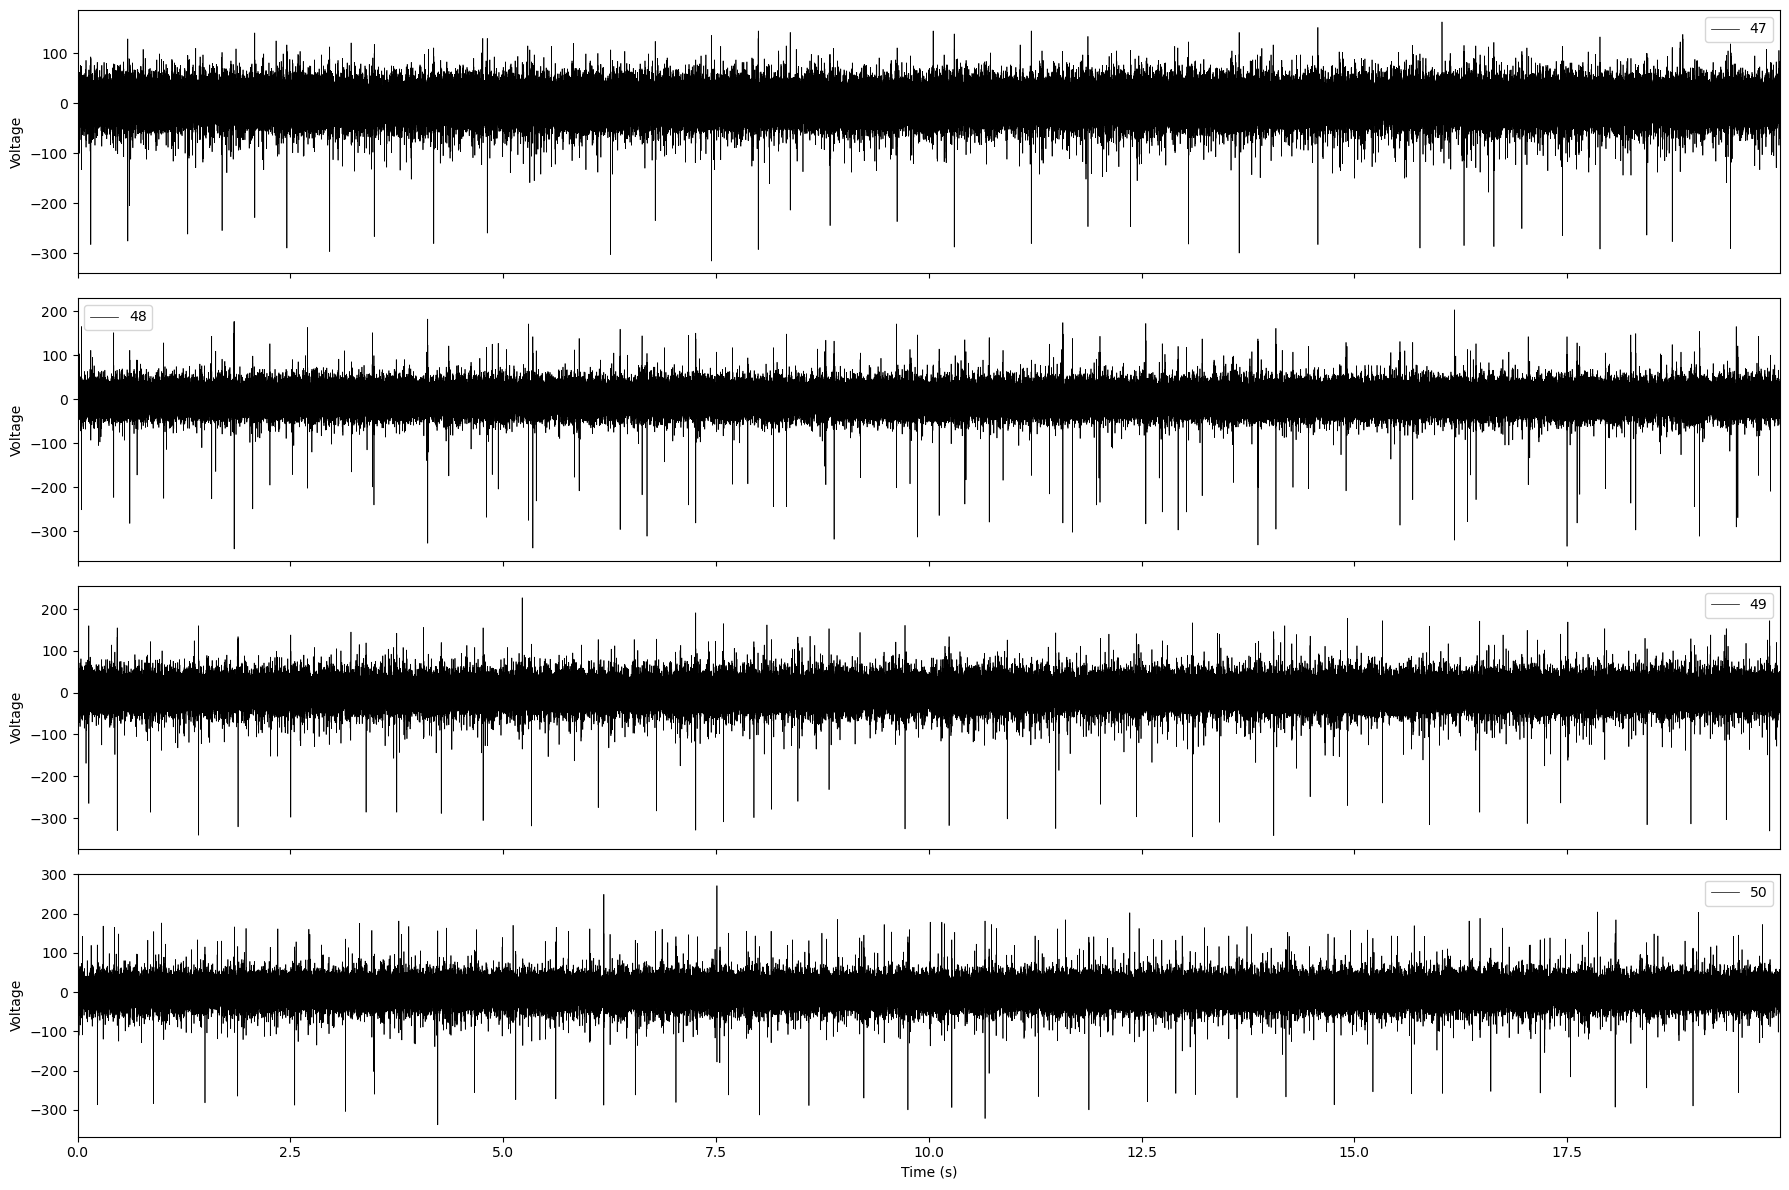

In [245]:
# create a time array for the x axis
time = np.arange(0, len(df)) / SAMPLE_RATE

fig, axs = plt.subplots(len(channels), sharex=True, figsize=(18, 3*len(channels)))

# plot each channel
for i, ax in enumerate(axs):
    ax.plot(time, data_filtered[:, i], label=channels[i], lw=0.5, c="k")
    ax.set_ylabel('Voltage')
    ax.legend()  # show a legend for each subplot

axs[-1].set_xlabel('Time (s)')  # only set x-label for the last subplot
plt.xlim(0, max(time))
plt.tight_layout()  # adjust subplot parameters to give specified padding
plt.show()

We can see the difference that filtering makes by comparing the first channel in the data before and after filtering.

As the software used in recording this data has a built-in high-pass filter, we can see there is not too much difference in the lower frequencies of the signals.

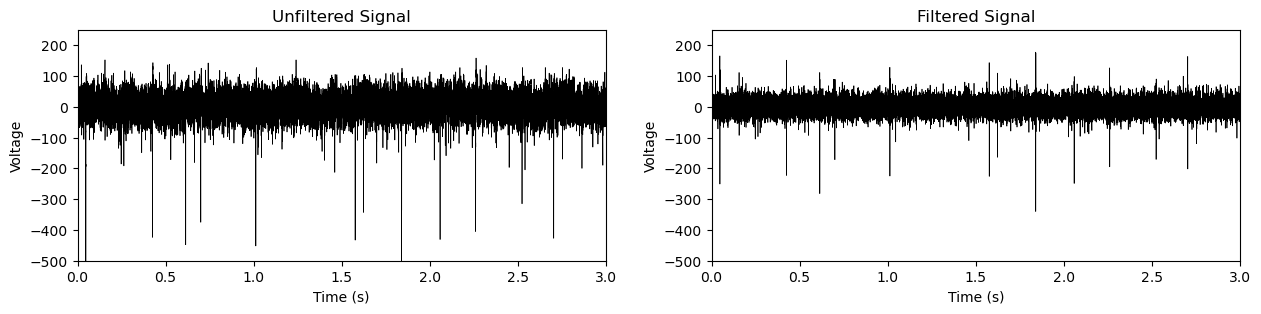

In [246]:
plt.figure(figsize=(15, 3))

# unfiltered signal plot
plt.subplot(1, 2, 1) 
plt.plot(time, data[:, 1], linewidth=.5, c="k")
plt.ylim((-500, 250))
plt.xlim((0, 3))
plt.ylabel('Voltage')
plt.title('Unfiltered Signal')
plt.xlabel("Time (s)")

# filtered signal plot
plt.subplot(1, 2, 2) 
plt.plot(time, data_filtered[:, 1], linewidth=.5, c="k")
plt.ylim((-500, 250))
plt.xlim((0, 3))
plt.ylabel('Voltage')
plt.title('Filtered Signal')
plt.xlabel("Time (s)")

plt.show()

## Spike Detection

In [247]:
# set a threshold mulitplier -> heuristic
threshold_factor = -5

# initialize spikes as an empty list
spikes = []

# loop through each of the channels
for i in range(data_filtered.shape[1]):

    # calculate robust s.d. using the mean absolute deviation (MAD)
    sigma = np.median(np.abs(data_filtered[:, i] - np.median(data_filtered[:, i])) / 0.6745)

    # set the threshold for this channel
    threshold = threshold_factor * sigma

    # detect spikes in this channel
    spikes_channel = detect_spikes(y=data_filtered[:, i], threshold=threshold, minimum_gap=1, use_absolute_threshold=True, flipped=True)

    # append the detected spikes to the list
    spikes.append(spikes_channel)

# convert spikes to a numpy array
spikes = np.array(spikes)

/var/folders/ct/68fpdtpx6lq75x8hr444s83h0000gn/T/ipykernel_10534/2040814929.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spikes = np.array(spikes)


The output array contains arrays of spike peak locations for each channel.

We can then visualise the threshold values for each channel and at which locations this threshold is crossed (a spike).

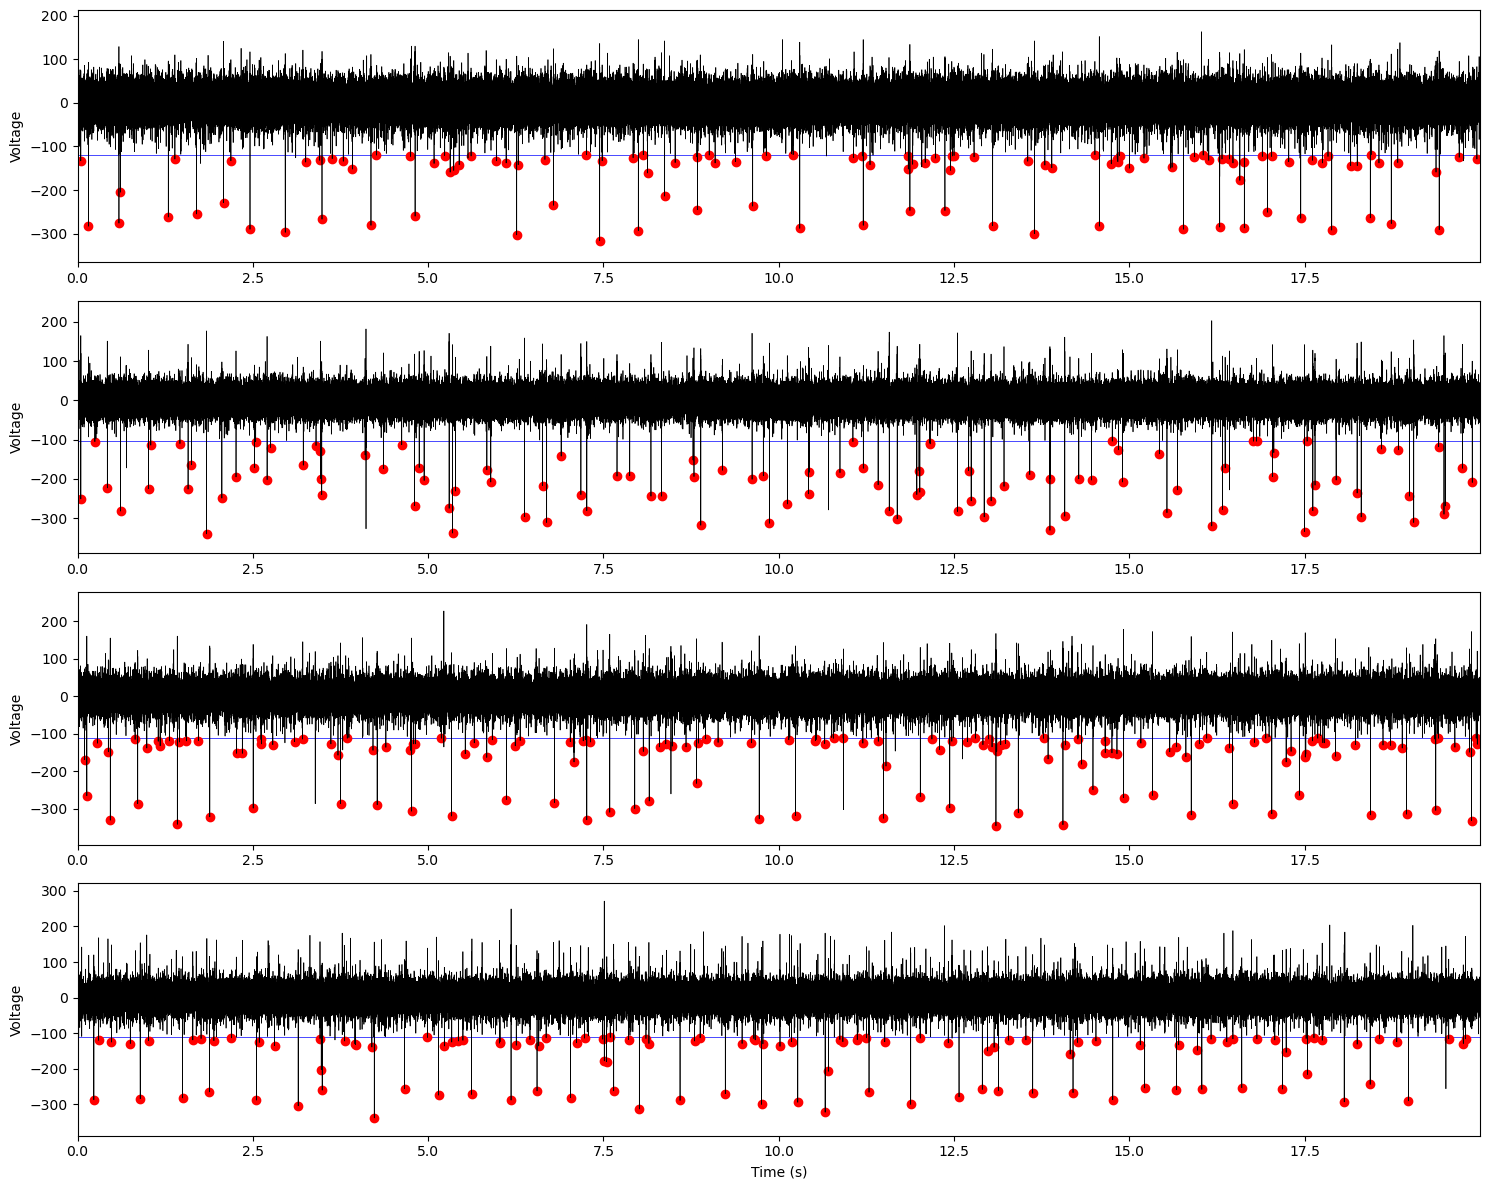

In [248]:
plt.figure(figsize=(15, 3 * data_filtered.shape[1]))

for i in range(data_filtered.shape[1]):
    plt.subplot(data_filtered.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(time, data_filtered[:, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data_filtered[:, i] - np.median(data_filtered[:, i])) / 0.6745)
    threshold = threshold_factor * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(spikes[i] * DT, data_filtered[spikes[i], i], color='red')
    
    plt.ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    plt.xlim((0, max(time)))
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [249]:
merged_spike_indices = merge_spike_indices(spikes, tolerance=2)

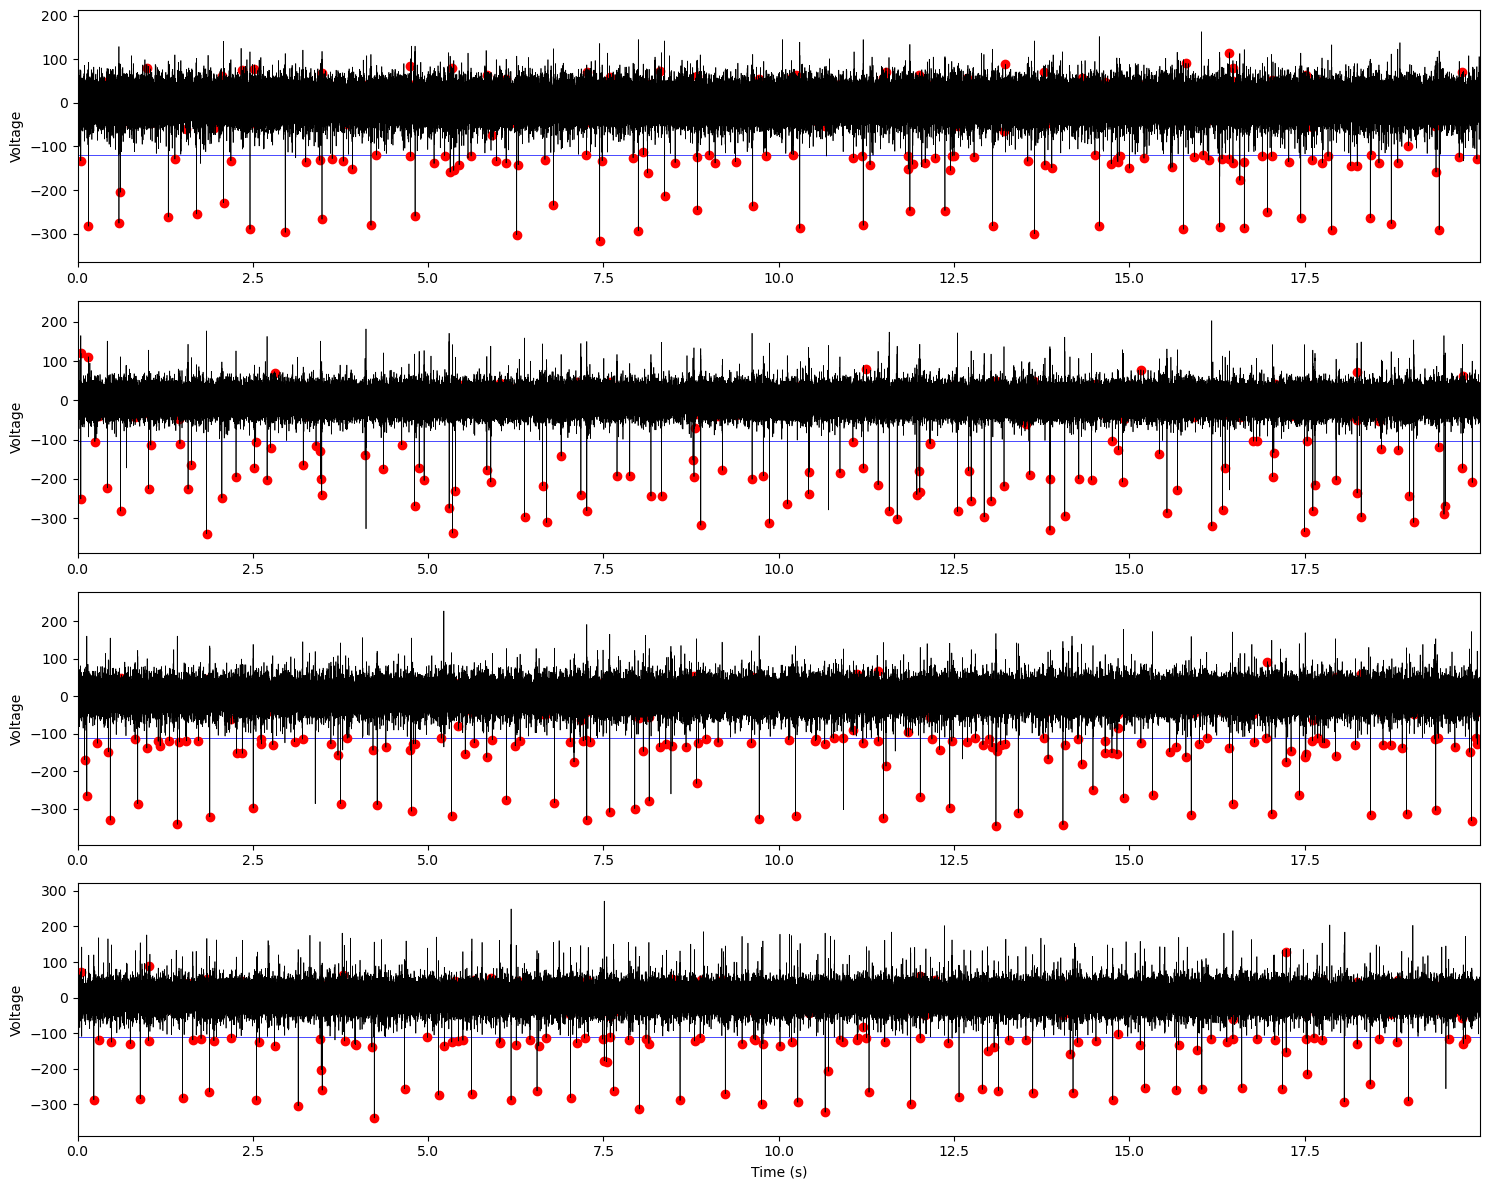

In [250]:
plt.figure(figsize=(15, 3 * data_filtered.shape[1]))

for i in range(data_filtered.shape[1]):
    plt.subplot(data_filtered.shape[1], 1, i+1)
    
    # Plot the signal for this channel
    plt.plot(time, data_filtered[:, i], linewidth=.5, c="k")
    
    # Plot the threshold for this channel
    sigma = np.median(np.abs(data_filtered[:, i] - np.median(data_filtered[:, i])) / 0.6745)
    threshold = threshold_factor * sigma
    plt.axhline(y=threshold, c="blue", linewidth=0.5, zorder=0)
    
    # Plot the spike locations for this channel
    plt.scatter(merged_spike_indices * DT, data_filtered[merged_spike_indices, i], color='red')
    
    plt.ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    plt.xlim((0, max(time)))
    plt.ylabel('Voltage')

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

## Waveform Extraction

In [251]:
waveforms = []
waveform_info = []

# loop through each of the channels
for i in range(data_filtered.shape[1]):
    # get waveforms for this channel
    # waveforms_channel, waveform_info_channel = get_waveforms(y=data_filtered[:, i], spike_indices=spikes[i], duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)
    waveforms_channel, waveform_info_channel = get_waveforms(y=data_filtered[:, i], spike_indices=merged_spike_indices, duration=1, sample_rate=SAMPLE_RATE, window_shift_ratio=1/3)
    
    # append the waveforms and waveform_info to the lists
    waveforms.append(waveforms_channel)
    waveform_info.append(waveform_info_channel)

# convert waveforms and waveform_info to numpy arrays
waveforms = np.array(waveforms)
waveform_info = np.array(waveform_info)

We can then show the waveforms for each channel overlapping...

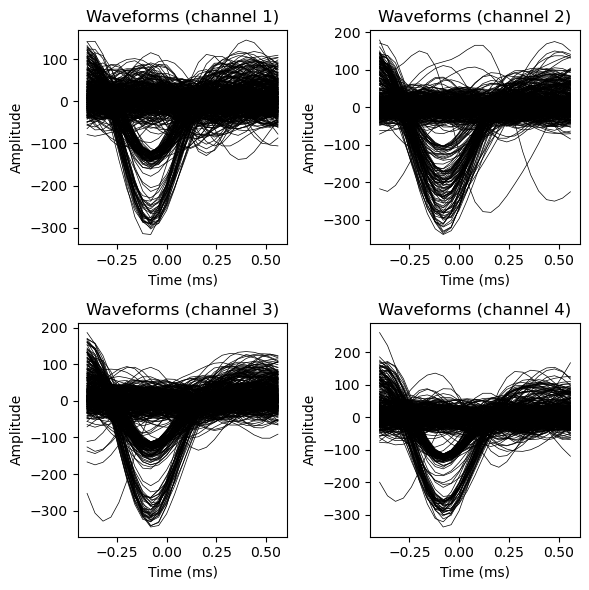

In [252]:
# determine the number of channels
n_channels = waveforms.shape[0]

# calculate the size of the grid
grid_size = int(np.sqrt(n_channels))

# create a figure and subplots
fig, axs = plt.subplots(grid_size, grid_size, figsize=(6, 6))

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(grid_size):
    for j in range(grid_size):
        channel_idx = i * grid_size + j
        # iterate over the waveforms in this channel and plot each on top of each other
        for waveform in waveforms[channel_idx]:

            t = np.arange(-10, 15) * DT * 1000             
            if len(waveform) == len(t):
                # plot the waveform
                axs[i, j].plot(t, waveform, c="black", lw=.5)

        axs[i, j].set_xlabel('Time (ms)')
        axs[i, j].set_ylabel('Amplitude')
        axs[i, j].set_title(f'Waveforms (channel {channel_idx+1})')

plt.tight_layout()
plt.show()

And how location of the spikes once they have been isolated from their parent signals...

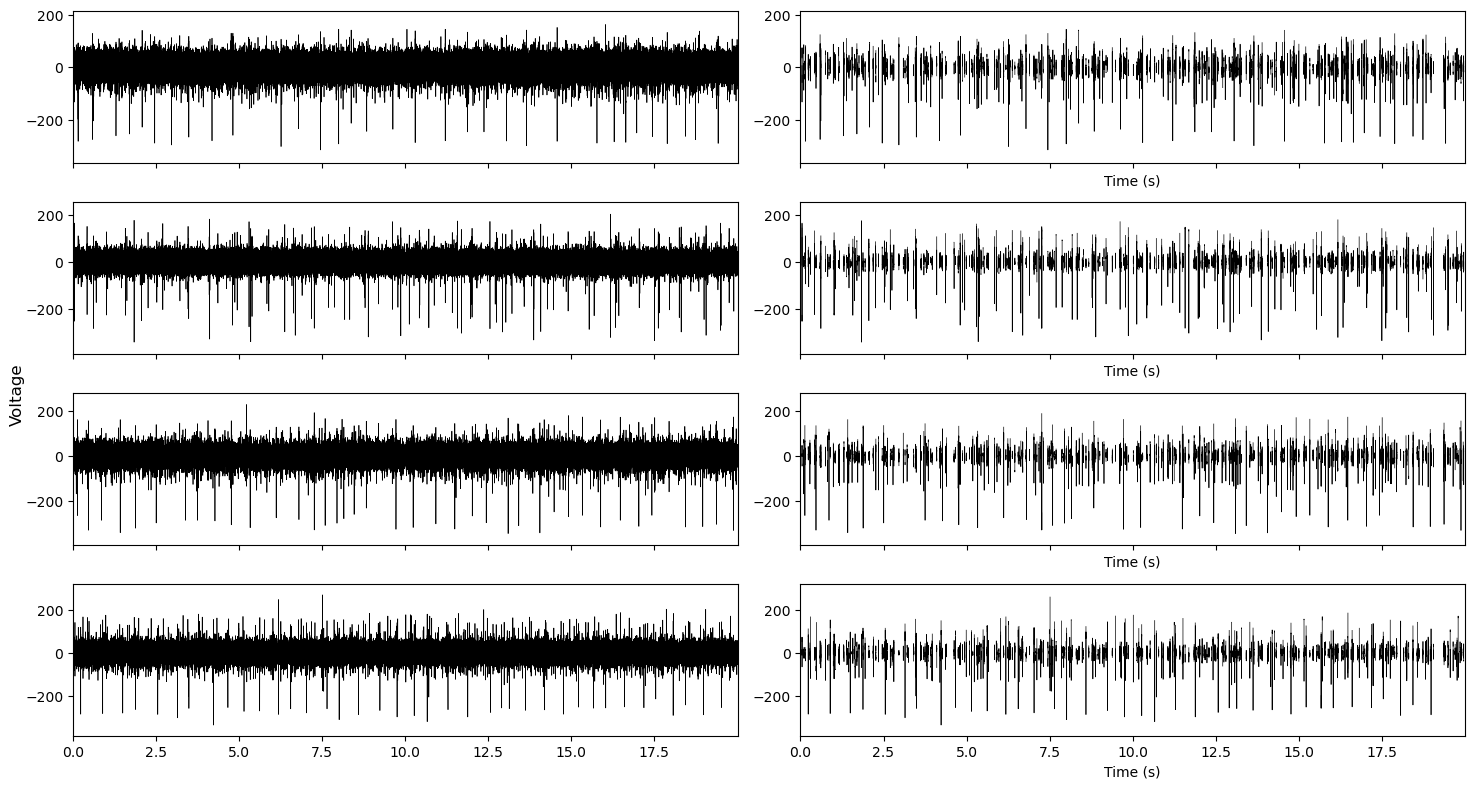

In [253]:
# determine the number of channels
n_channels = data_filtered.shape[1]

# create a figure and subplots
fig, axs = plt.subplots(n_channels, 2, figsize=(15, 2 * n_channels), sharex=True)

# make sure axs is always an array
if n_channels == 1:
    axs = np.array([[axs]])

# iterate over the channels
for i in range(n_channels):

    # plot the raw data for this channel
    axs[i, 0].plot(time, data_filtered[:, i], label='Raw Data', c='k', lw=0.5)
    axs[i, 0].set_ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    axs[i, 0].set_xlim((0, max(time)))
    
    # iterate through each spike and plot its waveform for this channel
    for spike in waveform_info[i]:
        spike_window = slice(spike["spike_start"], spike["spike_end"])
        axs[i, 1].plot(time[spike_window], data_filtered[:, i][spike_window], c='k', lw=0.5)

    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylim((min(data_filtered[:, i]) - 50, max(data_filtered[:, i]) + 50))
    axs[i, 1].set_xlim((0, max(time)))

fig.supylabel("Voltage")
plt.tight_layout()
plt.show()


## Feature Extraction

In [254]:
print(waveforms.shape)
waveforms[0]

(4, 470, 25)


array([[  6, -10, -30, ...,  42,  39,  38],
       [ 35,  55,  68, ..., -58, -48, -30],
       [ 53,  71,  83, ...,  13,  10,   6],
       ...,
       [ 18,   5, -13, ...,  13,  15,  15],
       [ 44,  17, -10, ...,   8,  14,  17],
       [  4,   2,   3, ..., -17, -17, -14]], dtype=int32)

In [255]:
n_components = 3

b = []
explained_variance_ratios = []
for i in range(waveforms.shape[0]):
    waveform = waveforms[i]

    # initialise PCA
    pca = PCA(n_components=n_components)

    b.append(pca.fit_transform(waveform))

    explained_variance_ratios.append(pca.explained_variance_ratio_)

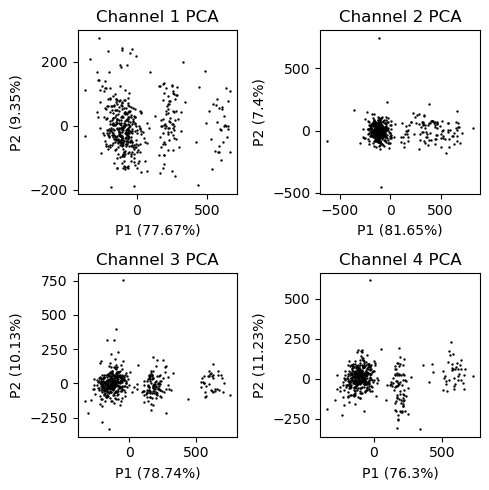

In [256]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5, 5))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]
    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=.5, c=PRIMARY_COLOUR)

plt.tight_layout()
plt.show()

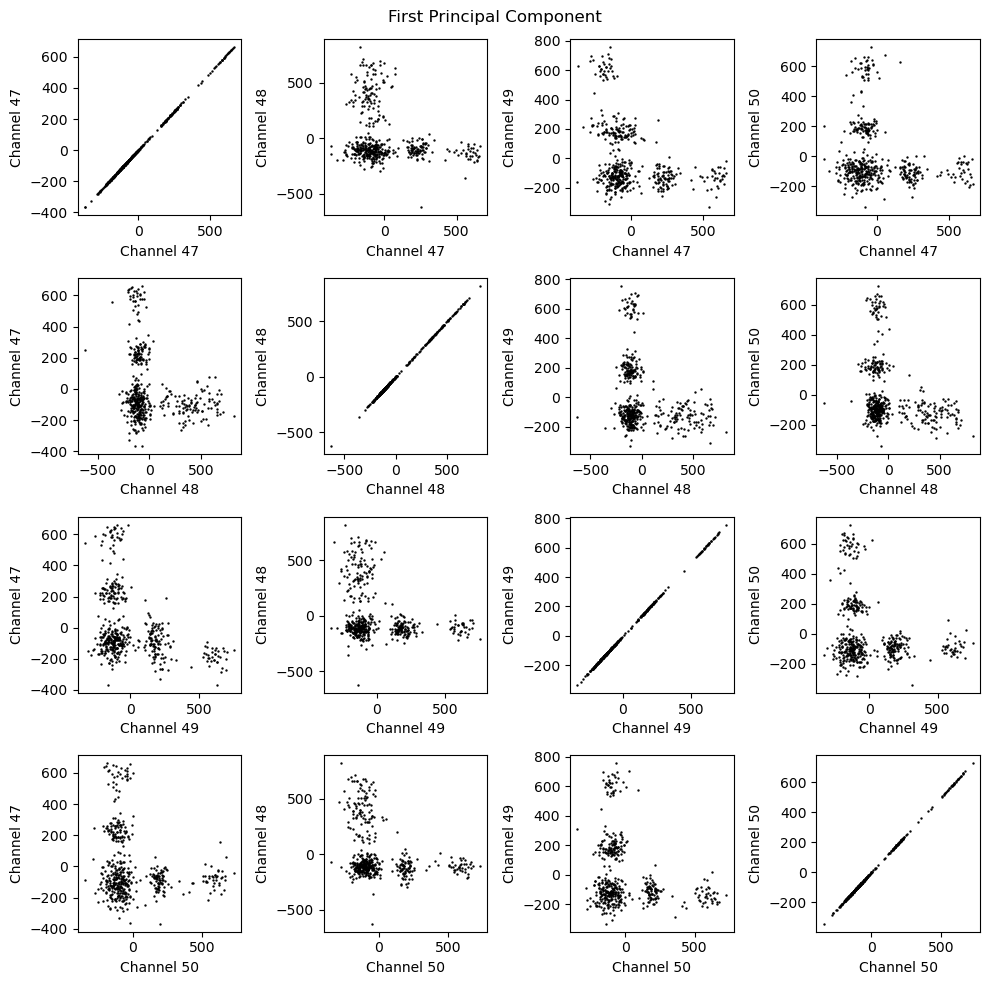

In [257]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(10, 10))

# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):
        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(b[i][:, 0], b[j][:, 0], c=PRIMARY_COLOUR, s=.5)
        axs[i, j].set_xlabel(f"Channel {channels[i]}")
        axs[i, j].set_ylabel(f"Channel {channels[j]}")

plt.suptitle("First Principal Component")
plt.tight_layout()
plt.show()

## Clustering

In [258]:
from sklearn.mixture import GaussianMixture 
from sklearn.preprocessing import StandardScaler

def mog(x: np.ndarray, k: int) -> Tuple[np.ndarray]:
    """
    Fit Mixture of Gaussian model
    ind, m, S, p = mog(x, k) fits a Mixture of Gaussian model to the data
    in x using k components. The output ind contains the MAP assignments of the
    datapoints in x to the found clusters. The outputs m, S, p contain
    the model parameters.

    Parameters
    ----------
    x: np.array 
        The datapoints -> N (Number of datapoints) x D (dimensionality of the data)
    k: int
        Number of clusters

    Returns
    ----------
    ind: np.array 
        Cluster indicators
    m: np.array
        Cluster means    (k x D)
    S: np.array 
        Cluster covarience matricies    (D x D x k)
    p: np.array 
        Cluster prior probabilities    (k x 1)
    """
    
    # fit the model
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(x)

    # get the MAP assignments of the data points
    ind = gmm.predict(x)

    # get the model parameters
    m = gmm.means_
    S = gmm.covariances_
    p = gmm.weights_


    return (ind, m, S, p)

from scipy.stats import multivariate_normal

def compute_log_likelihood(x, m, S, p):
    """
    Compute the log-likelihood of the data under the model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k by 1

    Returns:
        LL (float): Log-likelihood
    """
    k = m.shape[0]
    n = x.shape[0]
    LL = 0
    for i in range(n):
        temp = 0
        for j in range(k):
            try:
                temp += p[j] * multivariate_normal(m[j], S[j]).pdf(x[i])
            except:
                print(f"Covariance matrix for component {j} is not positive definite:")
                print(S[j])
                return
        LL += np.log(temp)
    return LL

def mog_bic(x, m, S, p):
    """
    Compute the BIC for a fitted Mixture of Gaussian model
    bic, LL = mog_bic(x,k) computes the the Bayesian Information 
    Criterion value and the log-likelihood of the fitted model.

    Parameters:
        x (np.array): N by D
        m (np.array): k by D
        S (np.array): D by D by k
        p (np.array): k

    Returns:
        bic (float): BIC
        LL (float): Log-likelihood
    """
    n, d = x.shape
    k = m.shape[0]

    # Compute the log-likelihood
    LL = compute_log_likelihood(x, m, S, p)

    # Compute the number of parameters
    P = k * (d + (d * (d + 1) / 2) + 1)

    # Compute the BIC
    bic = -2 * LL + P * np.log(n)
    
    return bic, LL

In [259]:
x = np.array(b)
x = np.transpose(x, (1, 0, 2)).reshape((-1, x.shape[0] * x.shape[2]))

In [260]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

# ind, m, S, p = mog(x, 6)
# bic, ll = mog_bic(x, m, S, p)

K = [2, 3, 4]
# K = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
BIC = np.zeros((len(K)))
LL = np.zeros((len(K)))

# loop over the number of clusters
for i, k in enumerate(K):
    # fit the GMM to the data
    ind, m, S, p = mog(x, k)

    # compute the BIC and log-likelihood
    bic, ll = mog_bic(x, m, S, p)

    # store the results
    BIC[i] = bic
    LL[i] = ll

print("BIC: \n", BIC)
print("Log-likelihood: \n", LL)

BIC: 
 [15501.4754781  15079.38502448 15000.81483432]
Log-likelihood: 
 [-7190.83906383 -6699.84449942 -6380.61006672]


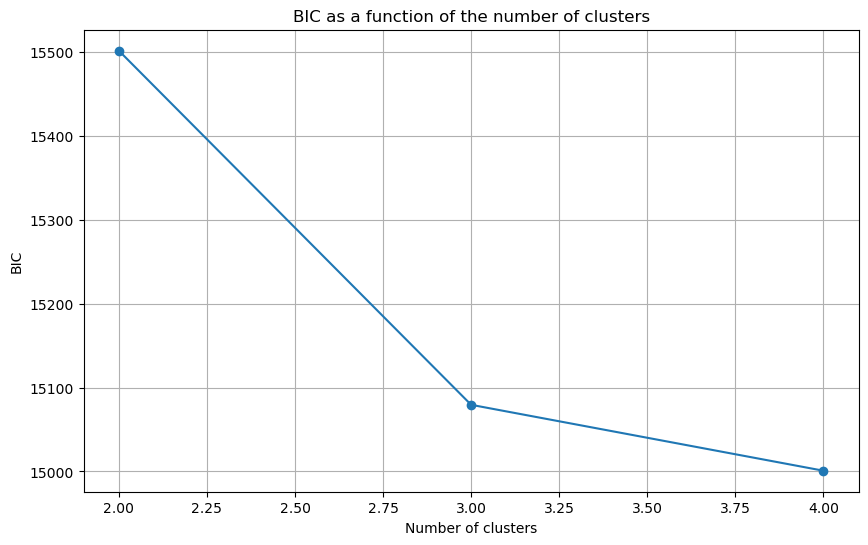

In [261]:
# plot the BIC as a function of the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(K, BIC, marker='o')
plt.title('BIC as a function of the number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.grid(True)
plt.show()

In [262]:
# number of clusters that gives the lowest BIC
optimal_k = K[np.argmin(BIC)]

# Refit the model with the optimal number of clusters
ind, m, S, p = mog(x, optimal_k)

In [263]:
# # Plot the data points and indicate the cluster each point was assigned to by the model
# plt.figure(figsize=(10, 6))
# for i in range(m.shape[0]):
#     plt.scatter(x[ind == i, 3], x[ind == i, 1], label=f'Cluster {i+1}', s=10)
#     plt.scatter(m[i, 0], m[i, 1], c='black')  # plot the mean of each cluster
# plt.legend()
# plt.title(f'Data points and cluster assignments by the model (k={4})')
# plt.xlabel('Dimension 1')
# plt.ylabel('Dimension 2')
# plt.grid(True)
# plt.show()

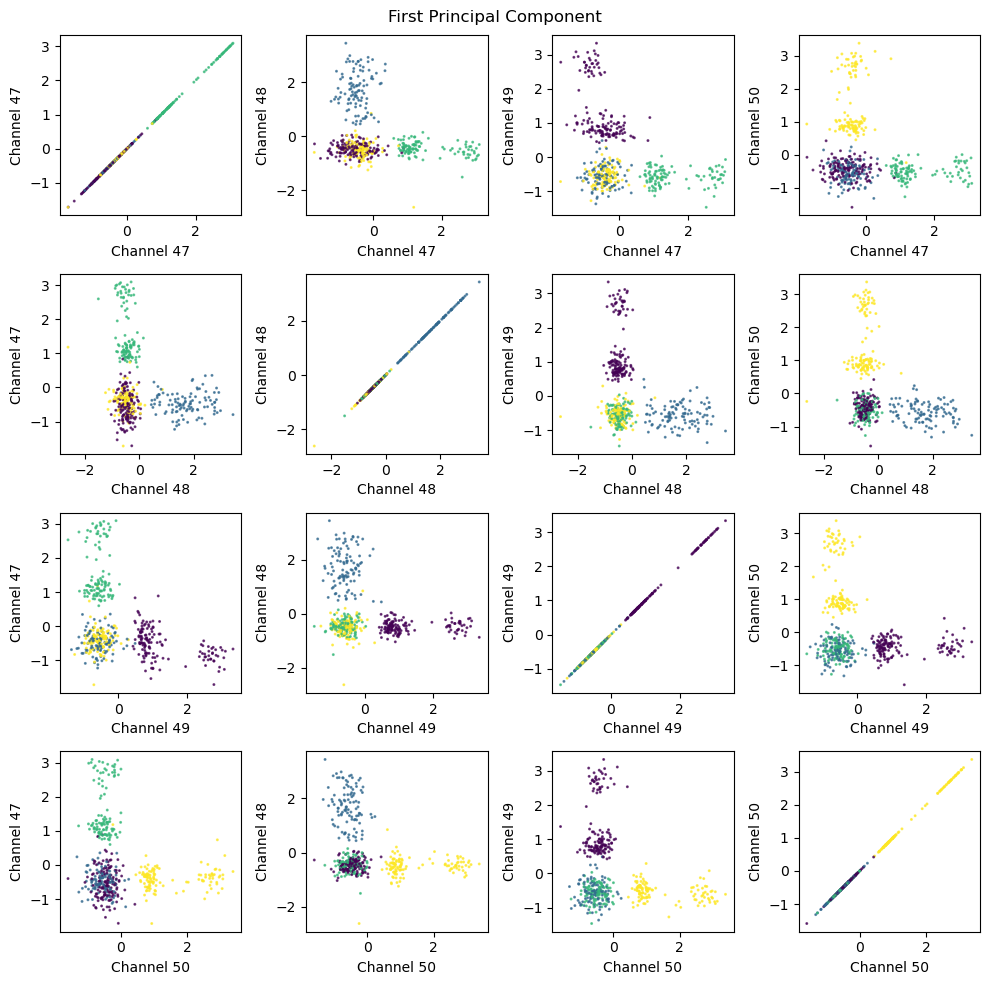

In [264]:
# Number of channels
num_channels = len(b)

# Create subplots
fig, axs = plt.subplots(num_channels, num_channels, figsize=(10, 10))

idx = [0, 3, 6, 9]
# Iterate through each pair of channels
for i in range(num_channels):
    for j in range(num_channels):
        # For each subplot, plot the first principal component of channel i against channel j
        axs[i, j].scatter(x[:,idx[i]], x[:,idx[j]], c=ind, cmap='viridis', s=5, marker='.', alpha=0.7) 
        axs[i, j].set_xlabel(f"Channel {channels[i]}")
        axs[i, j].set_ylabel(f"Channel {channels[j]}")

plt.suptitle("First Principal Component")
plt.tight_layout()
plt.show()

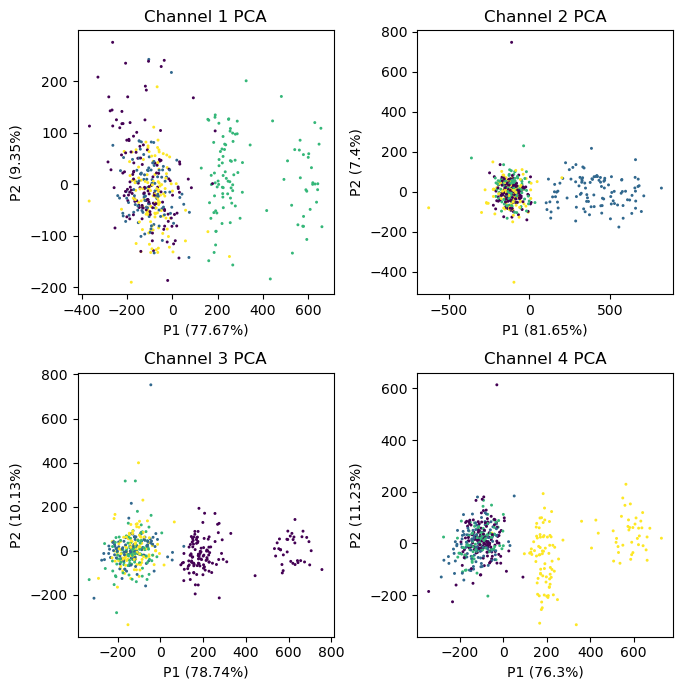

In [265]:
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 7))

for i, (data, evr) in enumerate(zip(b, explained_variance_ratios)):
    row = i // ncols
    col = i % ncols
    x = [point[0] for point in data]
    y = [point[1] for point in data]
    axs[row, col].set_title(f"Channel {i + 1} PCA")
    axs[row, col].set_xlabel(f"P1 ({round(evr[0] * 100, 2)}%)")
    axs[row, col].set_ylabel(f"P2 ({round(evr[1] * 100, 2)}%)")
    axs[row, col].scatter(x, y, s=5, c=ind, cmap='viridis', marker='.', alpha=1) 

plt.tight_layout()
plt.show()